## FRB160410

FRB verification criteria.

Criteria results:

* POSTIVE: good evidence for astrophysical origin
* NEUTRAL: neutral evidence
* UNKNOWN: unknown from reported data
* NEGATIVE: evidence for terrestrial origin (non-critical)
* CRITICAL: good evidence for terrestiral origin (critical)
* NOTVALID: not valid criterion for observation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lmfit
import cPickle as pkl

import astropy.time
import astropy.coordinates
import astropy.units

import dedispersion
import filterbankio
import frbutils

%matplotlib inline

In [2]:
sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 1.0})

In [3]:
criteria = {} # criteria status dictionary

### Parameters

[The first interferometric detections of fast radio bursts](https://arxiv.org/abs/1703.10173)

Data given by: Manisha Caleb

### Dynamic Spectrum (Component Optimized)

In [4]:
frbStr = 'FRB160410'
frbFil = '/Users/kaustub/Work/Molonglo_filterbanks/extract.fil' # Filterbank file of FRB event (aslxlap07)
fil = filterbankio.Filterbank(frbFil)

In [5]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = '277.8'

start_time = 2.5 # seconds
time_window = 1.0# seconds

applyGauss = True
fGauss = 2.0 # bins
tGauss = 2.0 # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [6]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

#### DM Excess

Using https://www.nrl.navy.mil/rsd/RORF/ne2001/

(RA, Dec) = (08:41:25, +06:05:05)

Galactic pointing: (l, b) = (220.4, 27.2)

In [7]:
DM_galaxy = 57.43
DM_excess = float(dm) / DM_galaxy
print 'DM Excess fraction:', DM_excess

DM Excess fraction: 4.83719310465


In [8]:
criteria['compDMfrac'] = 'POSITIVE' # contributions exceeds Galactic
criteria['snrDMfrac'] = 'NOTVALID' # multiple components

#### TIme Series
Since there is an issue with the way means are computed for Molonglo filterbanks, flip the signs of the output to make it consistent.

In [9]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
Tmean = np.mean(ddTimeSeries[0:400])
ddTimeSeries_base = ddTimeSeries - Tmean

In [10]:
ddTimeSeries_new = np.negative(ddTimeSeries_base)

In [11]:
#plt.plot(np.mean(decddwaterfall, axis=0))
print np.mean(decddwaterfall, axis=0).shape

print decddwaterfall.shape

normdecddwaterfall = decddwaterfall - np.mean(decddwaterfall, axis=0)
print normdecddwaterfall.shape
normdecddwaterfall_new = np.negative(normdecddwaterfall)

(40,)
(1525, 40)
(1525, 40)


#### Stokes I Plot

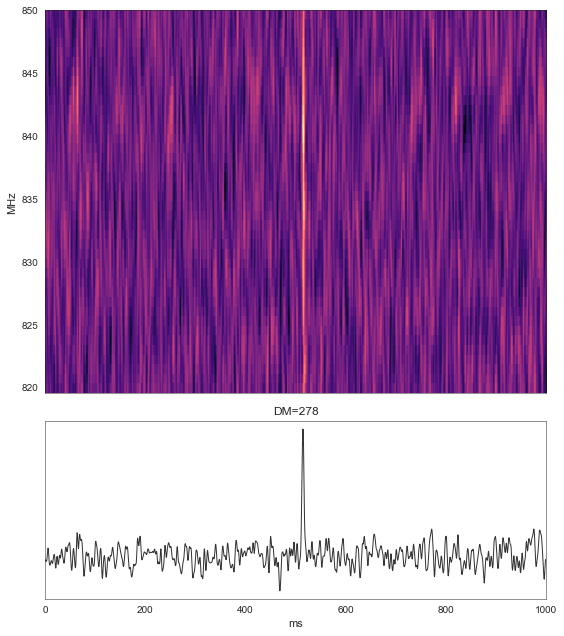

In [12]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})


fig = plt.figure(figsize=(8,9)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(normdecddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%float(dm))
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
#plt.savefig('%s_dynamic_dm%0.f.png'%(frbStr,dm))
plt.savefig('%s_dynamic.png'%(frbStr))

#### Signal to Noise

In [13]:
SNR = (ddTimeSeries.max() - ddTimeSeries.mean()) / ddTimeSeries.std()
print 'S/N:', SNR

S/N: 10.2085260074


In [14]:
criteria['SNR'] = 'POSITIVE' # High S/N

#### Boresight Flux

In [15]:
SEFD = 20. # Jy, approximate SEFD of Parkes L-band
flux = frbutils.flux(SEFD, SNR, 1, 2, tInt, (freqs[-1]-freqs[0])*1e6)
print 'flux: %f Jy'%flux

flux: 1.021670 Jy


In [16]:
criteria['flux'] = 'NEUTRAL' # low flux for the band

#### Components

In [17]:
### dynamic spectrum parameters
timeFactor = 2
freqFactor = 2
dm = 277.8

start_time = 2.5 # seconds
time_window = 1.0 # seconds

applyGauss = True
fGauss = 2.0 # bins
tGauss = 2.0 # bins

rfi =[]
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [18]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [19]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
Tmean = np.mean(ddTimeSeries[0:400])
ddTimeSeries_base = ddTimeSeries - Tmean

In [20]:
#plt.plot(np.mean(decddwaterfall, axis=0))
print np.mean(decddwaterfall, axis=0).shape

print decddwaterfall.shape

normdecddwaterfall = decddwaterfall - np.mean(decddwaterfall[0:400], axis=0)
print normdecddwaterfall.shape
normdecddwaterfall_new = np.negative(normdecddwaterfall)

(20,)
(762, 20)
(762, 20)


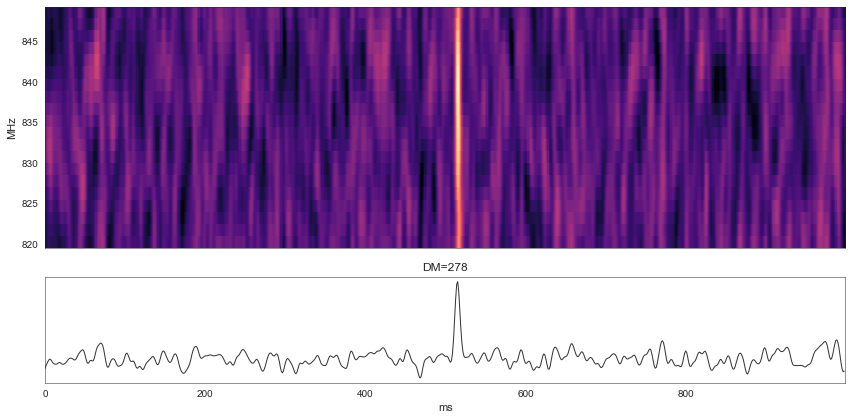

In [21]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(normdecddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%float(dm))
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

In [22]:
print ddTimeSeries_new.shape

(1525,)


[[Model]]
    (Model(constant) + Model(gaussian, prefix='nc0'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4031
    # data points      = 25
    # variables        = 4
    chi-square         = 3835.31641
    reduced chi-square = 182.634115
    Akaike info crit   = 133.828285
    Bayesian info crit = 138.703788
[[Variables]]
    c:             7310.35233 +/- 355573.193 (4863.97%) (init = 0)
    nc0sigma:      107.486097 +/- 4672.08440 (4346.69%) (init = 1)
    nc0center:     18.0471038 +/- 0.97189185 (5.39%) (init = 35)
    nc0amplitude: -1108567.91 +/- 1.4393e+08 (12983.28%) (init = 0.05)
    nc0fwhm:       253.110411 +/- 11001.9179 (4346.69%) == '2.3548200*nc0sigma'
    nc0height:    -4114.52871 +/- 355355.482 (8636.60%) == '0.3989423*nc0amplitude/max(1.e-15, nc0sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(c, nc0amplitude)         = -1.000
    C(nc0sigma, nc0amplitude)  = -1.000
    C(c, nc0sigma)             =  1.000
    C(c, n

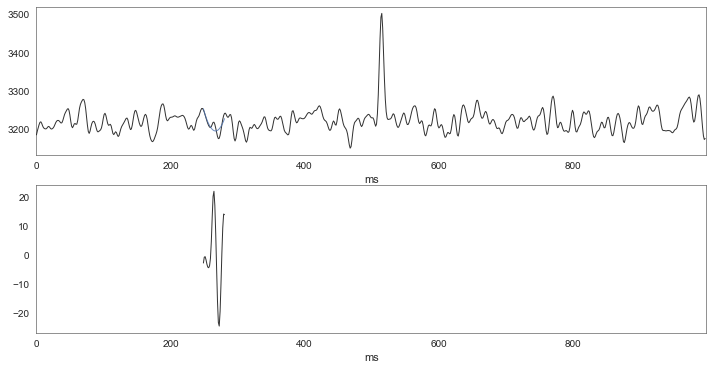

In [23]:
# Assume pulse can be modelled as a set of Gaussian components on a constant offset
nComponents = 1 # number of components in pulse

pulseModel = lmfit.models.ConstantModel()
for nc in np.arange(nComponents):
    gaussComp = lmfit.models.GaussianModel(prefix='nc%i'%nc)
    pulseModel += gaussComp

#print pulseModel
params = pulseModel.make_params(nc0center=35., nc0sigma=1., nc0amplitude=0.05, nc1center=40., nc1sigma=1., nc1amplitude=0.05)
#params = pulseModel.make_params()

#select only region around pulse for fit
tIdx0 = 190
tIdx1 = 215
ddTimeSeriesCent = ddTimeSeries[tIdx0:tIdx1]
result = pulseModel.fit(ddTimeSeriesCent, params, x=1000.*tInt*np.arange(ddTimeSeriesCent.shape[0]))
print result.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot(2,1,1)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(ddTimeSeries.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), result.best_fit, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

ax2 = plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(1000.*tInt*(np.arange(ddTimeSeriesCent.shape[0])+tIdx0), ddTimeSeriesCent - result.best_fit,\
         lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.xlabel('ms')

print 'NCOMPONENTS:', nComponents
for nc in np.arange(nComponents):
    print 'FWHM%i (ms):'%nc, result.params['nc%ifwhm'%nc].value

In [24]:
criteria['pulsewidth'] = 'NEUTRAL' # fit to a single component model
criteria['multicomp'] = 'NEGATIVE' # no multiple components

### Polarization

In [25]:
criteria['polarization'] = 'NOTVALID' # not recorded

### Spectral Index

In [26]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 277.8

start_time = 2.5 # seconds
time_window = 1.0 # seconds

applyGauss = True
fGauss = 2. # bins
tGauss = 2. # bins

rfi = []
#rfi = [[205,235], [840,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [27]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [28]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

In [29]:
print decddwaterfall.shape

(1525, 40)


In [30]:
# upper and lower frequency of pulse
# if pulse goes to the edge of beam, set to None
upperFreqMHz = freqs[39]
lowerFreqMHz = freqs[0]
obsFracBand = (freqs[-1]-freqs[0]) / ((freqs[-1]+freqs[0])/2.) # observational fractional bandwidth
print 'START OBS FREQ (MHz):', freqs[0]
print 'STOP OBS FREQ (MHz):', freqs[-1]
print 'BANDWIDTH (MHz):', freqs[-1]-freqs[0]
print 'FRACTIONAL OBS BANDWIDTH:', obsFracBand
print 'FRACTIONAL PULSE BANDWIDTH:', (upperFreqMHz - lowerFreqMHz) / ((upperFreqMHz+lowerFreqMHz)/2.)

START OBS FREQ (MHz): 819.53125
STOP OBS FREQ (MHz): 850.0
BANDWIDTH (MHz): 30.46875
FRACTIONAL OBS BANDWIDTH: 0.0364997660271
FRACTIONAL PULSE BANDWIDTH: 0.0364997660271


In [31]:
criteria['broadband'] = 'POSITIVE'

In [32]:
# region to use for spectral index fit

# select between freq limits
upperFreqIdx = np.argmin(np.abs(freqs - upperFreqMHz))
lowerFreqIdx = np.argmin(np.abs(freqs - lowerFreqMHz))

# select around peak
peakIdx = np.unravel_index(np.argmax(decddwaterfall), decddwaterfall.shape)
tWidth = 3 # number of time stample to take on eiter side of peak

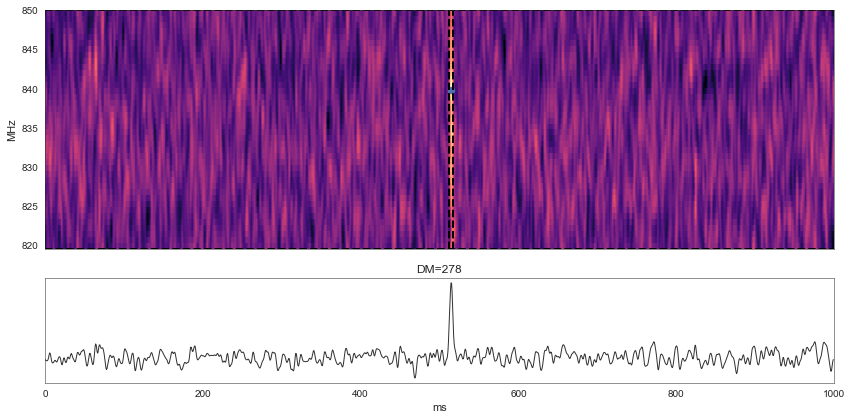

In [33]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
# crop out RFI flagged high freqs
#imRaw = plt.imshow(np.flipud(decddwaterfall[:,:850].T), extent=(0, tInt*decddwaterfall.shape[0],\
#                        freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.axhline(y=upperFreqMHz, c='k', lw=2, ls='--')
plt.axhline(y=lowerFreqMHz, c='k', lw=2, ls='--')
plt.scatter(tInt*peakIdx[0], freqs[peakIdx[1]])
plt.axvline(x=tInt*(peakIdx[0]-tWidth), c='k', lw=2, ls='--')
plt.axvline(x=tInt*(peakIdx[0]+tWidth), c='k', lw=2, ls='--')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

[[Model]]
    (Model(constant) + Model(powerlaw))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8004
    # data points      = 39
    # variables        = 3
    chi-square         = 279647.342
    reduced chi-square = 7767.98172
    Akaike info crit   = 352.231195
    Bayesian info crit = 357.221880
[[Variables]]
    c:         -7346.48693 +/- 1287877.01 (17530.52%) (init = 0)
    exponent:   0.46998343 +/- 55.4223860 (11792.41%) (init = 1)
    amplitude:  0.70117382 +/- 876.314002 (124978.14%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(exponent, amplitude) = -1.000
    C(c, amplitude)        = -1.000
    C(c, exponent)         =  1.000

SPECTRAL INDEX: 0.469983430173


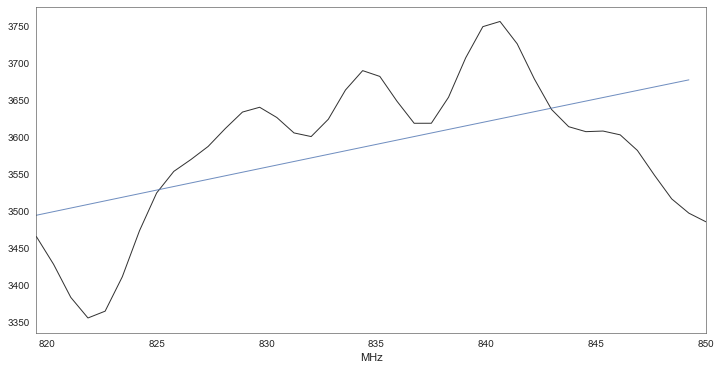

In [34]:
spectralRaw = decddwaterfall[peakIdx[0]-tWidth:peakIdx[0]+tWidth].mean(axis=0)

vaildFreqMask = np.zeros_like(spectralRaw)
vaildFreqMask[lowerFreqIdx:upperFreqIdx] = 1.
for freqPair in rfi:
    vaildFreqMask[freqPair[0]:freqPair[1]] = 0.

spectralModel = lmfit.models.ConstantModel() + lmfit.models.PowerLawModel()
spectralParams = spectralModel.make_params()
spectralResult = spectralModel.fit(spectralRaw[vaildFreqMask.astype(bool)],\
                                   spectralParams, x=freqs[vaildFreqMask.astype(bool)]*1e6)
print spectralResult.fit_report()

fig = plt.figure(figsize=(12,6)) # (width, height)

lineColor = 'k'
plt.plot(freqs, spectralRaw, lineColor, alpha=0.8)
plt.plot(freqs[vaildFreqMask.astype(bool)], spectralResult.best_fit, alpha=0.8)

plt.axvspan(freqs[0], freqs[lowerFreqIdx], alpha=0.3)
plt.axvspan(freqs[upperFreqIdx], freqs[-1], alpha=0.3)
for freqPair in rfi:
    plt.axvspan(freqs[freqPair[0]/freqFactor], freqs[freqPair[1]/freqFactor], alpha=0.3)

plt.xlabel('MHz')
plt.xlim(freqs[0], freqs[-1])

print 'SPECTRAL INDEX:', spectralResult.params['exponent'].value

In [35]:
criteria['spectralIndex'] = 'NEGATIVE' # approximately flat across the band

### High-resolution Structure

In [36]:
### dynamic spectrum parameters
timeFactor = 2
freqFactor = 2
dm = 277.8

start_time = 2.9 # seconds
time_window = 0.2 # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [37]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [38]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)

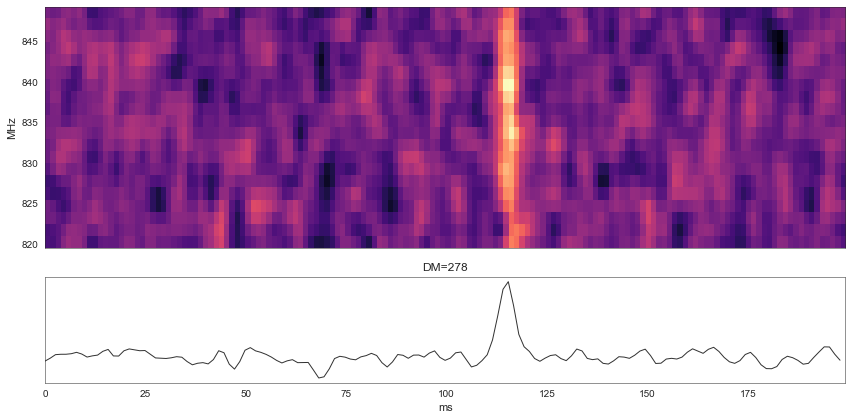

In [39]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax2.get_yaxis().set_visible(False)

plt.tight_layout()

In [40]:
criteria['highResStruct'] = 'NEUTRAL' # difficiult to tell, maybe the components are more boxcar than Gaussian

### Scattering

* compute scatter timescale in time series (function)

In [41]:
criteria['scattering'] = 'NOTVALID'

### Scintillation

* compute characteristic scintillation bandwidth, FFT of spectrum (function)

In [42]:
criteria['scintillation'] = 'NOTVALID'

### DM Trial Space

In [43]:
# High-res
timeFactor = 4

minDM = 270.0
maxDM = 280.0
dmStep = 0.1

start_time = 2.5 # seconds
time_window = 1.0 # seconds

applyGauss = False
fGauss = 2. # bins
tGauss = 2. # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [44]:
dmSpaceArr, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (280.000000): 121.810977816


Text(0.5,0,u't (ms)')

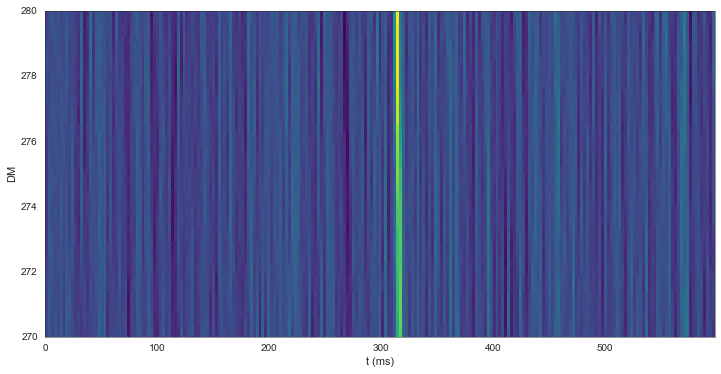

In [45]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 200. # (start) ms
tClipHigh = 600. # (width) ms
plt.imshow(np.flipud(dmSpaceArr[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [46]:
# Low-res
timeFactor = 16

minDM = -400
maxDM = 400
dmStep = 4

start_time = 2. # seconds
time_window = 2. # seconds

applyGauss = False
fGauss = 2. # bins
tGauss = 2. # bins

rfi = []
#rfi = [[205,235], [940,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [47]:
dmSpaceArrLow, tInt, freqs = frbutils.dmSpace(frbFil, start_time, time_window,
                                          minDM, maxDM, dmStep, timeFactor, rfi=rfi)

Maximum delay (ms) based on maximum DM (400.000000): 174.015682594


Text(0.5,0,u't (ms)')

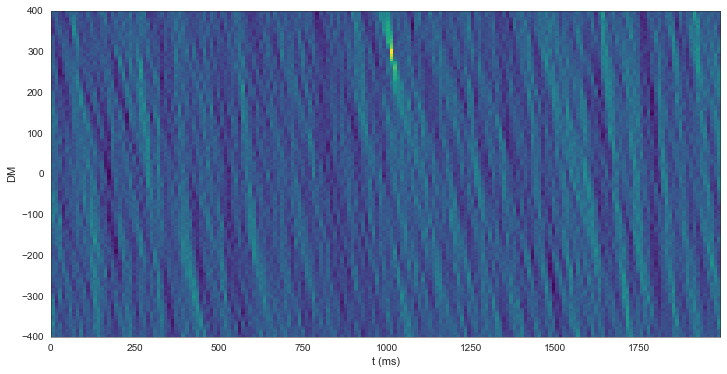

In [48]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 0. # (start) ms
tClipHigh = 2000. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

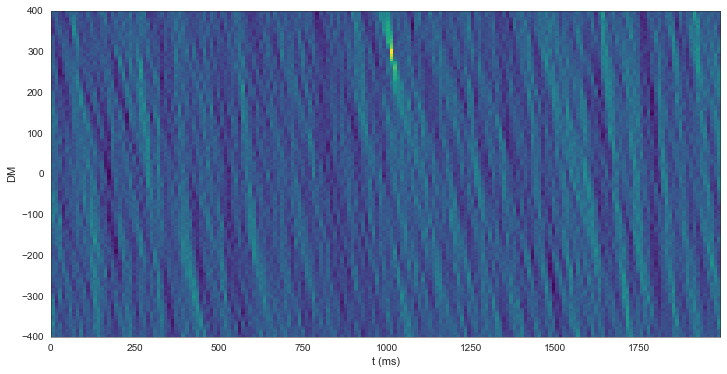

In [49]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 0. # (start) ms
tClipHigh = 2000. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

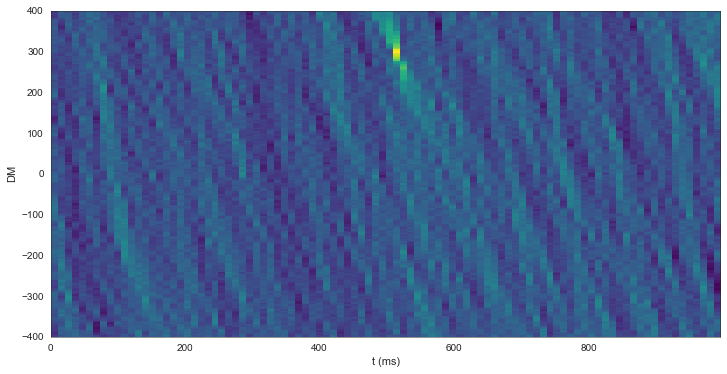

In [50]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 500. # (start) ms
tClipHigh = 1000. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

Text(0.5,0,u't (ms)')

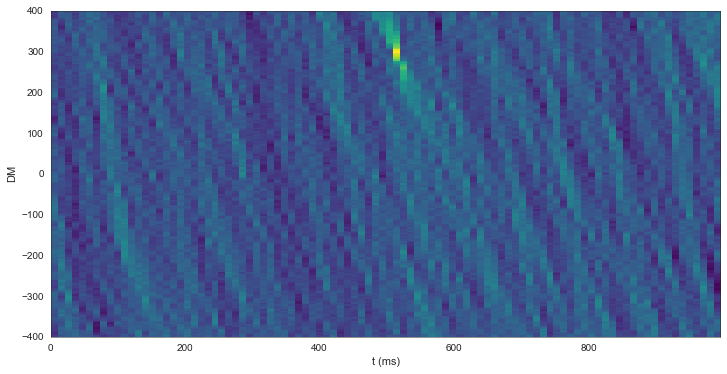

In [51]:
cmap = 'viridis'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

tClipLow = 500. # (start) ms
tClipHigh = 1000. # (width) ms
plt.imshow(np.flipud(dmSpaceArrLow[:,int((tClipLow/1000.)/tInt):int(((tClipLow+tClipHigh)/1000.)/tInt)]),\
           aspect='auto',\
           extent=(0, 1000.*tInt*int((tClipHigh/1000.)/tInt), minDM, maxDM),\
           cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('DM')
plt.xlabel('t (ms)')
#plt.colorbar(fraction=0.025)

In [52]:
# No other bright regions in the DM trial space
# No obvious bias in positive or negative DM trial
criteria['dmSpace'] = 'POSITIVE'

### Dispersion Relation

In [53]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 277.8

start_time = 2.0 # seconds
time_window = 2.0 # seconds

applyGauss = True
fGauss = 1. # bins
tGauss = 1. # bins

rfi = []
#rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

normalize = False

In [54]:
decwaterfall, decddwaterfall, tInt, freqs = frbutils.dynamicSpectrum(frbFil, start_time, time_window,
                                                timeFactor=timeFactor, freqFactor=freqFactor,
                                                dm=dm,
                                                applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                                rfi=rfi)

In [55]:
ddTimeSeries = np.mean(decddwaterfall, axis=1)
startIdx = np.argmax(ddTimeSeries)
startTime = startIdx * tInt # seconds

In [56]:
if normalize:
    meanGain = np.median(decwaterfall, axis=1)
    decwaterfall = decwaterfall / meanGain[:, None]

    meanBP = np.mean(decwaterfall, axis=0)
    decwaterfall = decwaterfall / meanBP[None, :]

In [ ]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(cutoutDynamicSpectrum), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')
plt.xlabel('s')

1480 1617


Text(0.5,0,u's')

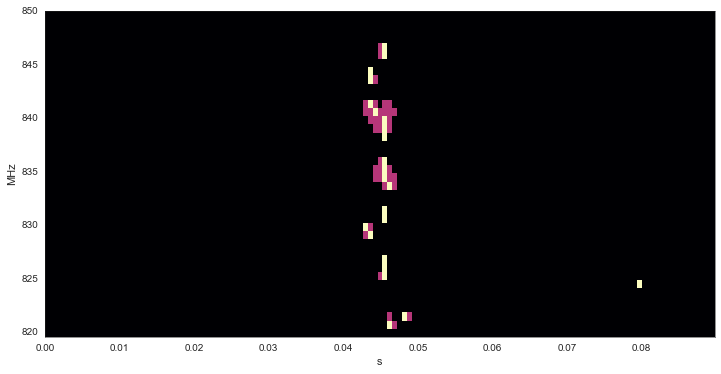

In [58]:
# Find peaks in dedispersed dynamic spectrum
# assuming a near nu^-2 relation, but pick a wide region to allow for variation
peakSearchWidth = .09 # s, time width to find peaks
peakStartTime = startTime - (peakSearchWidth / 2.)
peakStartIdx = int(peakStartTime / tInt)
peakStopTime = startTime + (peakSearchWidth / 2.)
peakStopIdx = int(peakStopTime / tInt)
print peakStartIdx, peakStopIdx

cutoutDynamicSpectrum = np.copy(decddwaterfall[peakStartIdx:peakStopIdx].T)
cutoutDynamicSpectrum -= np.mean(cutoutDynamicSpectrum)

snrThresh = 3.
stdDSpec = np.std(cutoutDynamicSpectrum)

delays = dedispersion.delay(freqs * 1e6, dm) # seconds
#print delays

binaryMask = np.where(cutoutDynamicSpectrum > snrThresh * stdDSpec, 0.5, 0)

validFidx = []
validTidx = []
validDelays = []
validSNR = []

for fIdx in np.arange(cutoutDynamicSpectrum.shape[0]): # loop over frequency channels
    subband = cutoutDynamicSpectrum[fIdx]
    # select only pixels above a threshold
    subPeakIdx = np.argmax(subband)
    if (subband[subPeakIdx] > snrThresh * stdDSpec):
        binaryMask[fIdx, subPeakIdx] = 1.
        validFidx.append(fIdx)
        validTidx.append(subPeakIdx)
        validSNR.append(subband[subPeakIdx] / stdDSpec)

validFreqs = freqs[validFidx]
validDelays = (np.array(validTidx) * tInt) - (peakSearchWidth / 2.) + delays[validFidx] + startTime
validSNR = np.array(validSNR)
#print validFreqs # MHz
#print validDelays # seconds
#print validSNR

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(binaryMask), extent=(0, tInt*cutoutDynamicSpectrum.shape[1],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.ylabel('MHz')
plt.xlabel('s')

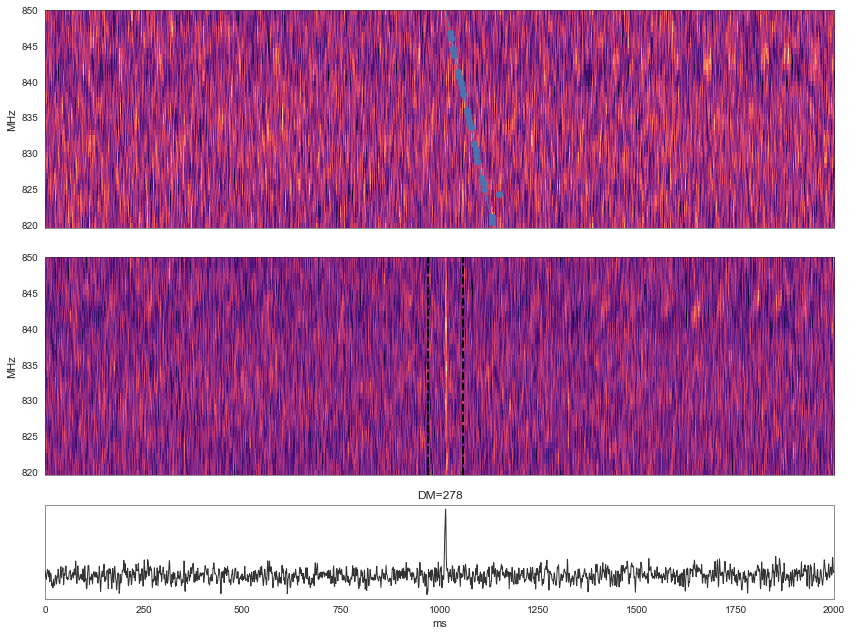

In [59]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,9)) # (width, height)

ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)

plt.scatter(validDelays, validFreqs)

ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((5, 3), (2, 0), colspan=3, rowspan=2)

imRaw = plt.imshow(np.flipud(decddwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

plt.axvline(x=peakStartTime, c='k', lw=2, ls='--')
plt.axvline(x=peakStopTime, c='k', lw=2, ls='--')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

ax2.get_xaxis().set_visible(False)

ax3 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
lineColor = 'k'
plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, 1000.*tInt*ddTimeSeries.shape[0])
plt.title('DM=%0.f'%dm)
plt.xlabel('ms')
ax3.get_yaxis().set_visible(False)

plt.tight_layout()

#### Build Power Law Model

In [60]:
model = lmfit.models.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff', independent_vars=['nu1', 'nu2'])

print model
print model.param_names
print model.independent_vars

<lmfit.ExpressionModel('amp * (nu1**(alpha) - nu2**(alpha)) - toff')>
['amp', 'alpha', 'toff']
['nu1', 'nu2']


In [61]:
nu1 = validFreqs.copy()
nu2 = np.ones_like(validFreqs) * freqs[-1]

In [62]:
params = model.make_params(amp=dm * 4.148808e3, alpha=-2., toff=-1.*startTime)
#params['alpha'].set(min=-2.5, max=-1.5)
print params

Parameters([('amp', <Parameter 'amp', 1152538.8624, bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', -2.0, bounds=[-inf:inf]>), ('toff', <Parameter 'toff', -1.0151526173095704, bounds=[-inf:inf]>)])


In [63]:
#print model.eval(params, nu1=nu1, nu2=nu2)
#print validDelays

In [64]:
out  = model.fit(validDelays, params, nu1=nu1, nu2=nu2, weights=validSNR)
print out.fit_report()

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8002
    # data points      = 23
    # variables        = 3
    chi-square         = 0.00986179
    reduced chi-square = 4.9309e-04
    Akaike info crit   = -172.355386
    Bayesian info crit = -168.948903
[[Variables]]
    amp:    1.1823e+19 +/- 6.8826e+20 (5821.32%) (init = 1152539)
    alpha: -6.62312283 +/- 8.92214408 (134.71%) (init = -2)
    toff:  -1.01446508 +/- 0.00530407 (0.52%) (init = -1.015153)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, alpha)  = -1.000
    C(alpha, toff) =  0.844
    C(amp, toff)   = -0.844



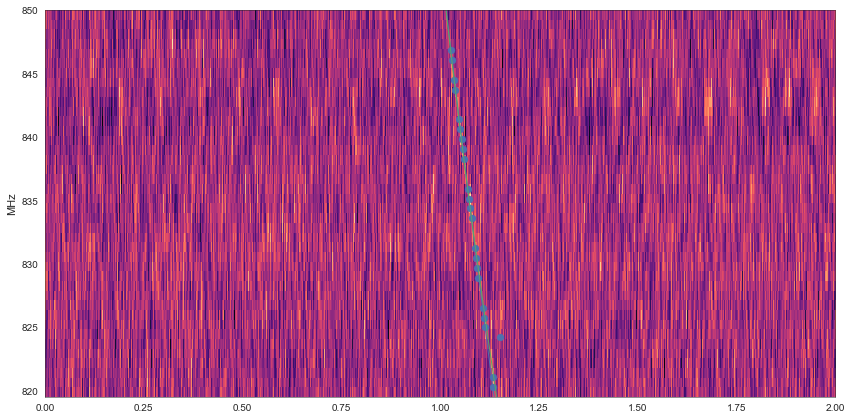

In [65]:
alphaBest = out.best_values['alpha']
ampBest = out.best_values['amp']
toffBest = out.best_values['toff']
nu1Full = freqs
nu2Full = freqs[-1]

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

imRaw = plt.imshow(np.flipud(decwaterfall.T), extent=(0, tInt*decddwaterfall.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

for rfiPair in rfi:
    plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
plt.ylabel('MHz')

plt.plot(((dm * (4.15 * (10.**6) * (freqs**(-2.) - freqs[-1]**(-2.))))/1000.) + startTime, freqs)
plt.plot(ampBest * (nu1Full**(alphaBest) - nu2Full**(alphaBest)) - toffBest, freqs)


plt.scatter(validDelays, validFreqs)

plt.tight_layout()

In [ ]:
# Fits well to a nu^-2 dispersion relation
criteria['dispersionRelation'] = 'POSITIVE'

### Telescope Response

In [ ]:
offFrbFil = '/local/griffin/data/FRB/FRB090625/FRB090625_s0r10b8_b06.fil' # beam 6, ~3 minutes earlier

onFil = filterbankio.Filterbank(frbFil)
ontInt = onFil.header['tsamp'] # get tInt
onFreqsHz = onFil.freqs * 1e6 # generate array of freqs in Hz
onFreqs = onFreqsHz / 1e6 # MHz
onWaterfall = np.reshape(onFil.data, (onFil.data.shape[0], onFil.data.shape[2]))

offFil = filterbankio.Filterbank(offFrbFil)
offtInt = offFil.header['tsamp'] # get tInt
offFreqsHz = offFil.freqs * 1e6 # generate array of freqs in Hz
offWaterfall = np.reshape(offFil.data, (offFil.data.shape[0], offFil.data.shape[2]))

In [ ]:
# Bandpass

onMeanBP = onWaterfall.mean(axis=0)
onMinBP = onWaterfall.min(axis=0)
onMaxBP = onWaterfall.max(axis=0)
onMedianBP = np.median(onWaterfall, axis=0)

offMeanBP = offWaterfall.mean(axis=0)
offMinBP = offWaterfall.min(axis=0)
offMaxBP = offWaterfall.max(axis=0)
offMedianBP = np.median(offWaterfall, axis=0)

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(onFreqs, onMeanBP, 'g-')
plt.plot(onFreqs, onMedianBP, 'g--')
#plt.plot(onFreqs, onMinBP, 'g.')
#plt.plot(onFreqs, onMaxBP, 'g.-')
plt.fill_between(onFreqs, onMinBP, onMaxBP, color='g', alpha=0.2)

plt.plot(onFreqs, offMeanBP, 'b-')
plt.plot(onFreqs, offMedianBP, 'b--')
#plt.plot(onFreqs, offMinBP, 'b.')
#plt.plot(onFreqs, offMaxBP, 'b.-')

plt.xlim(onFreqs[0], onFreqs[-1])
plt.xlabel('Mhz')

plt.tight_layout()

In [ ]:
criteria['bandpass'] = 'UNKNOWN' # data has been bandpass normalized

In [ ]:
# Gain

onMeanGain = onWaterfall.mean(axis=1)
onMinGain = onWaterfall.min(axis=1)
onMaxGain = onWaterfall.max(axis=1)
onMedianGain = np.median(onWaterfall, axis=1)

offMeanGain = offWaterfall.mean(axis=1)
offMinGain = offWaterfall.min(axis=1)
offMaxGain = offWaterfall.max(axis=1)
offMedianGain = np.median(offWaterfall, axis=1)

tRange = np.arange(onMeanGain.shape[0]) * ontInt

cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(12,6)) # (width, height)

plt.plot(tRange, onMeanGain, 'g-')
#plt.plot(onFreqs, onMedianGain, 'g--')
#plt.plot(onFreqs, onMinGain, 'g.')
#plt.plot(onFreqs, onMaxGain, 'g.-')
#plt.fill_between(onFreqs, onMinGain, onMaxGain, color='g', alpha=0.2)

plt.plot(tRange, offMeanGain, 'b-')
#plt.plot(onFreqs, offMedianGain, 'b--')
#plt.plot(onFreqs, offMinGain, 'b.')
#plt.plot(onFreqs, offMaxGain, 'b.-')

plt.xlim(0, onMeanGain.shape[0] * ontInt)
plt.xlabel('s')

plt.tight_layout()

In [ ]:
criteria['gain'] = 'UNKNOWN' # data has been gain normalized

### Telescope State

In [ ]:
# Telescope pointing

eventUTCStr = '2009-06-25 21:53:51.379'
eventUTC = astropy.time.Time(eventUTCStr)
print eventUTC

eventGall = 226.444
eventGalb = -60.0303

galCoords = astropy.coordinates.SkyCoord(eventGall, eventGalb, frame=astropy.coordinates.Galactic,\
                                         unit='deg', equinox='J2000')
print galCoords

# Parkes location
# https://www.parkes.atnf.csiro.au/observing/documentation/user_guide/pks_ug_2.html
siteLat = -32.99778
siteLong = 148.26292
siteLoc = astropy.coordinates.EarthLocation(lat=siteLat * astropy.units.deg, lon=siteLong * astropy.units.deg,\
                                  height=414.80 * astropy.units.m)
print siteLoc

print galCoords.transform_to(astropy.coordinates.AltAz(obstime=eventUTC, location=siteLoc))

print galCoords.transform_to('icrs')

In [ ]:
criteria['lowAltitude'] = 'UNKNOWN' # high-altitude pointing

In [ ]:
criteria['sysNoise'] = 'UNKNOWN' # system noise nominal?
criteria['correctFeed'] = 'UNKNOWN' # was the feed in the corrct position?
criteria['obsLog'] = 'UNKNOWN' # was the observation log checked to be nominal?
criteria['electronics'] = 'UNKNOWN' # were the correct electornics on? were other systems off?

### Follow-Up Observations

In [ ]:
# Unknown if follow-up observations or a pulsar search were done
criteria['repeats'] = 'UNKNOWN'
criteria['lowSNRsearch'] = 'UNKNOWN'

### Multi-Beam

In [ ]:
### dynamic spectrum parameters
timeFactor = 1
freqFactor = 1
dm = 899.5

start_time = 7.3 # seconds
time_window = 0.15 # seconds

applyGauss = True
fGauss = 4. # bins
tGauss = 4. # bins

rfi = [[805,820], [850,1023]] # frequency channels to flag as rfi, pairs are the edges of bands

In [ ]:
def multiBeamPlot():
    decwaterfallBeam, decddwaterfallBeam, tInt, freqs = frbutils.dynamicSpectrum(frbFilBeam,
                                          start_time, time_window,
                                          timeFactor=timeFactor, freqFactor=freqFactor,
                                          dm=dm,
                                          applyGauss=applyGauss, fGauss=fGauss, tGauss=tGauss,
                                          rfi=rfi)

    ddTimeSeriesBeam = np.mean(decddwaterfallBeam, axis=1)

    cmap = 'magma'
    sns.set_style('white', rc={'axes.linewidth': 0.5})

    fig = plt.figure(figsize=(12,6)) # (width, height)

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

    imRaw = plt.imshow(np.flipud(decddwaterfallBeam.T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
                        freqs[0], freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
    # crop out RFI flagged high freqs
    #imRaw = plt.imshow(np.flipud(decddwaterfallBeam[:,:850].T), extent=(0, tInt*decddwaterfallBeam.shape[0],\
    #                    freqs[0], freqs[850]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

    for rfiPair in rfi:
        plt.axhspan(freqs[rfiPair[0]/freqFactor], freqs[rfiPair[1]/freqFactor], alpha=0.4, color='y')
    plt.ylabel('MHz')

    ax1.get_xaxis().set_visible(False)

    ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
    lineColor = 'k'
    plt.plot(1000.*tInt*np.arange(decddwaterfallBeam.shape[0]), ddTimeSeriesBeam, lineColor, alpha=0.8)
    plt.plot(1000.*tInt*np.arange(decddwaterfall.shape[0]), ddTimeSeries, 'r', alpha=0.4) # pulse time series
    plt.xlim(0, 1000.*tInt*ddTimeSeriesBeam.shape[0])
    plt.title('DM=%0.f'%dm)
    plt.xlabel('ms')
    ax2.get_yaxis().set_visible(False)

    plt.tight_layout()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b01.fil' # beam 01 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b02.fil' # beam 02 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b03.fil' # beam 03 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b04.fil' # beam 04 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b05.fil' # beam 05 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b06.fil' # beam 06 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b07.fil' # beam 07 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b08.fil' # beam 08 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b09.fil' # beam 09 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b10.fil' # beam 10 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b11.fil' # beam 11 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b12.fil' # beam 12 (aslxlap07)
multiBeamPlot()

In [ ]:
frbFilBeam = '/local/griffin/data/FRB/FRB090625/FRB090625_s193r10b8_b13.fil' # beam 13 (aslxlap07)
multiBeamPlot()

In [ ]:
# No pulse present in any of the other beams, possibly present in beam 12
criteria['multiBeam'] = 'POSITIVE'

### Tied-Array Beam

In [ ]:
criteria['TAB'] = 'NOTVALID'

### Interferometric Observations

In [68]:
criteria['interferometric'] = 'NOTVALID'

### Multi-Site

In [69]:
criteria['multiSite'] = 'NOTVALID'

### Available Data

In [70]:
criteria['dataSingleBeam'] = 'NOTVALID'
criteria['dataMultiBeam'] = 'NEUTRAL' # filterbanks have been normalized
criteria['dataTAB'] = 'NOTVALID'
criteria['dataInterferometric'] = 'NOTVALID'
criteria['dataMultiSite'] = 'NOTVALID'
criteria['dataVoltages'] = 'NOTVALID'

### Report Output

In [66]:
for key in criteria.iterkeys():
    print '%s: %s'%(key, criteria[key])

outFn = 'criteria.%s.pkl'%frbStr
ofh = open(outFn, 'wb')
pkl.dump(criteria, ofh)
ofh.close()

spectralIndex: NEGATIVE
dmSpace: POSITIVE
snrDMfrac: NOTVALID
compDMfrac: POSITIVE
multicomp: NEGATIVE
broadband: POSITIVE
scintillation: NOTVALID
highResStruct: NEUTRAL
polarization: NOTVALID
flux: NEUTRAL
pulsewidth: NEUTRAL
SNR: POSITIVE
scattering: NOTVALID
